In [3]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

operator_names = ("Conjunction", "Disjunction", "Filter", "Average", "Join", "SelfJoin", "Stream", "Sequence")

def is_operator_name(file):
    if file.__contains__("~lock"):
        return False
    
    for op in operator_names:
        if file.__contains__(op):
            return True
    return False


if __name__ == '__main__':
    sample_filepath = os.path.join(os.getenv("HOME"), "Downloads/geni_yahoo")
    sample_files = [ file for file in os.listdir(sample_filepath) if is_operator_name(file) ]
    #print(sample_files)
    samples = pd.DataFrame()
    discarded_lines = 0
    for filename in sample_files:
        path = os.path.join(sample_filepath, filename)
        if os.path.isfile(path):
            #print("processing ", path)
            with open(path) as f:
                df = pd.read_csv(f, sep=";", header=0)._get_numeric_data()
                if not df.empty:
                    df = df.dropna()
                     #filter irrelevant lines
                    size_before = len(df.index)
                    df = df[ df["eventSizeInKB"] > 0]
                    df = df[ df["eventSizeOutKB"] > 0]
                    df = df[ df["eventRateIn"] > 0]
                    df = df[ df["e2eLatencyMean"] > 0]
                    size_after = len(df.index)
                    #print("discarded ", size_before - size_after)
                    discarded_lines += size_before - size_after
                    samples = samples.append(df)
        else:
            print("invalid path: ", path)
            
    #print(samples)
    print("total samples: ", len(samples.index), ", discarded: ", discarded_lines)
    samples.to_csv(sample_filepath + '/combined_samples.csv', index=False, sep=';')

total samples: %s, discarded: %s 11760294 3284


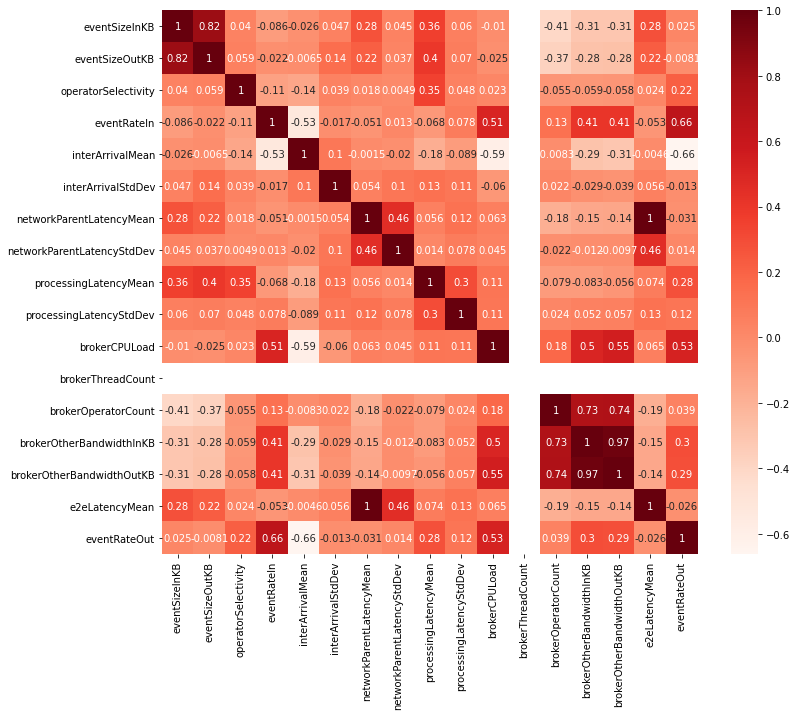

In [4]:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # plot heatmap to visualize feature-wise correlations
    # -> guidance for feature selection: select relevant features and avoid selecting highly correlated features
    df = pd.read_csv(sample_filepath + '/combined_samples.csv', sep=';')
    # Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
